Đây là phiên bản hồi quy của Decision Tree mà bạn đã học trong phân loại. Ý tưởng vẫn là chia dữ liệu thành các vùng, nhưng thay vì dự đoán nhãn, nó dự đoán giá trị trung bình trong mỗi vùng.

Mình sẽ trình bày theo đúng phong cách quen thuộc:

🔹 1. Nguyên lý hoạt động (không công thức nặng!)
🎯 Mục tiêu:
Dự đoán giá trị số liên tục bằng cách chia không gian đặc trưng thành các vùng, và trong mỗi vùng, dự đoán giá trị trung bình của các mẫu huấn luyện.

🧠 Ý tưởng chính — “Chia nhỏ để dự đoán chính xác hơn”
Thay vì vẽ một đường thẳng (như Linear Regression), Decision Tree Regressor:
Hỏi: "Diện tích > 100 m² không?"
Nếu có → dự đoán giá trung bình của các nhà >100m².
Nếu không → chia tiếp: "Số phòng ≥ 3 không?" → rồi dự đoán giá trung bình trong nhóm nhỏ hơn.
→ Cứ thế, càng chia sâu, dự đoán càng sát với dữ liệu huấn luyện.

🔍 Làm sao chọn "câu hỏi tốt nhất"?
Không dùng Gini/Entropy như trong phân loại.
Mà dùng phương sai (variance) hoặc MSE (Mean Squared Error):
Chọn cách chia sao cho tổng MSE của hai nhóm con là nhỏ nhất. 
→ Tức là: các điểm trong cùng nhóm càng gần giá trị trung bình, càng tốt.

💡 Ví dụ trực quan:
Nhóm 1 (diện tích ≤ 100): giá nhà = [1.2, 1.3, 1.1] tỷ → dự đoán = 1.2 tỷ
Nhóm 2 (diện tích > 100): giá nhà = [2.5, 2.7, 2.4] tỷ → dự đoán = 2.53 tỷ
→ Khi có nhà mới diện tích 90m² → dự đoán 1.2 tỷ.

✅ Ưu điểm:
Không giả định tuyến tính → xử lý phi tuyến rất tốt.
Không cần chuẩn hóa dữ liệu.
Xử lý được đặc trưng hỗn hợp (số + phân loại).
Tự động chọn đặc trưng quan trọng.
❌ Hạn chế:
Dễ overfit nếu cây quá sâu.
Dự đoán "bậc thang" — không mượt như Linear Regression.
Không ngoại suy tốt (nếu giá trị mới nằm ngoài phạm vi huấn luyện).

 3. Khi nào dùng Decision Tree Regressor?
Mối quan hệ
phi tuyến, phức tạp
Cần
dự đoán mượt
(tree cho kết quả "bậc thang")
Dữ liệu
hỗn hợp
(số + phân loại)
Dữ liệu
rất nhiễu
→ cây dễ overfit
Bạn cần
giải thích mô hình
(xem cây chia thế nào)
Cần
ngoại suy
(dự đoán ngoài phạm vi dữ liệu huấn luyện)
Làm
baseline nhanh
cho hồi quy phi tuyến
Bài toán
rủi ro cao
→ hãy dùng
Random Forest Regressor
thay vì cây đơn

🎯 So sánh nhanh với Linear Regression:
Mối quan hệ
Chỉ tuyến tính
✅
Phi tuyến tốt
Giải thích
Hệ số = ảnh hưởng
Cấu trúc cây = logic chia
Overfit
Ít (nếu không có đa cộng tuyến)
✅
Dễ overfit
Chuẩn hóa
Nên
Không cần
Dự đoán
Mượt, liên tục
"Bậc thang", rời rạc theo vùng
Tốc độ
Rất nhanh
Nhanh

✅ MSE (tự code): 835.58
✅ R² (tự code): 0.9084
🔍 Sklearn MSE: 761.31
🔍 Sklearn R²: 0.9166


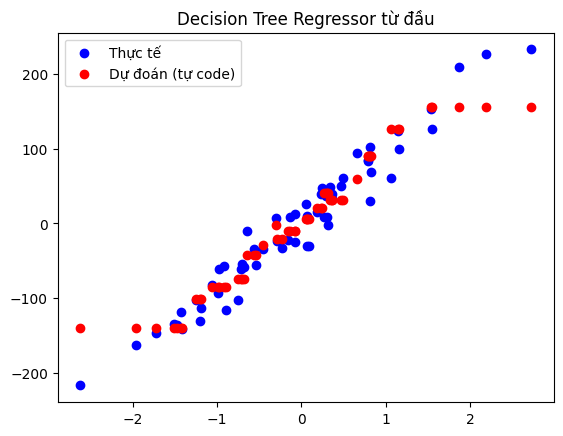

In [1]:
import numpy as np

class SimpleDecisionTreeRegressor:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

    def _mse(self, y):
        """Tính Mean Squared Error so với giá trị trung bình"""
        if len(y) == 0:
            return 0
        return np.var(y) * len(y)  # tương đương sum((y - mean)^2)

    def _best_split(self, X, y):
        """Tìm đặc trưng & ngưỡng chia để giảm MSE nhiều nhất"""
        best_mse = float('inf')
        best_split = {}
        n_features = X.shape[1]

        for feat_idx in range(n_features):
            thresholds = np.unique(X[:, feat_idx])
            for th in thresholds:
                left_mask = X[:, feat_idx] <= th
                right_mask = ~left_mask

                if np.sum(left_mask) < self.min_samples_split or np.sum(right_mask) < self.min_samples_split:
                    continue

                # Tính MSE tổng sau chia
                mse_left = self._mse(y[left_mask])
                mse_right = self._mse(y[right_mask])
                total_mse = mse_left + mse_right

                if total_mse < best_mse:
                    best_mse = total_mse
                    best_split = {
                        'feature_idx': feat_idx,
                        'threshold': th,
                        'mse': best_mse
                    }
        return best_split

    def _build_tree(self, X, y, depth=0):
        """Xây dựng cây hồi quy đệ quy"""
        n_samples = len(y)

        # Điều kiện dừng
        if (depth >= self.max_depth or 
            n_samples < self.min_samples_split):
            leaf_value = np.mean(y)
            return {'leaf': True, 'value': leaf_value}

        best_split = self._best_split(X, y)
        if not best_split:
            leaf_value = np.mean(y)
            return {'leaf': True, 'value': leaf_value}

        # Chia dữ liệu
        left_mask = X[:, best_split['feature_idx']] <= best_split['threshold']
        right_mask = ~left_mask

        # Đệ quy
        left_child = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_child = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return {
            'leaf': False,
            'feature_idx': best_split['feature_idx'],
            'threshold': best_split['threshold'],
            'left': left_child,
            'right': right_child
        }

    def fit(self, X, y):
        self.tree = self._build_tree(np.array(X), np.array(y))

    def _predict_sample(self, x, tree):
        if tree['leaf']:
            return tree['value']
        if x[tree['feature_idx']] <= tree['threshold']:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])

# --- Thử nghiệm ---
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Tạo dữ liệu hồi quy phi tuyến
X, y = make_regression(n_samples=200, n_features=1, noise=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Huấn luyện mô hình tự code
tree_reg = SimpleDecisionTreeRegressor(max_depth=5, min_samples_split=5)
tree_reg.fit(X_train, y_train)
y_pred = tree_reg.predict(X_test)

# Đánh giá
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"✅ MSE (tự code): {mse:.2f}")
print(f"✅ R² (tự code): {r2:.4f}")

# So sánh với sklearn
from sklearn.tree import DecisionTreeRegressor
sk_tree = DecisionTreeRegressor(max_depth=5, min_samples_split=5, random_state=42)
sk_tree.fit(X_train, y_train)
sk_pred = sk_tree.predict(X_test)
sk_mse = mean_squared_error(y_test, sk_pred)
sk_r2 = r2_score(y_test, sk_pred)
print(f"🔍 Sklearn MSE: {sk_mse:.2f}")
print(f"🔍 Sklearn R²: {sk_r2:.4f}")

# Vẽ kết quả (nếu 1 đặc trưng)
if X.shape[1] == 1:
    import matplotlib.pyplot as plt
    plt.scatter(X_test, y_test, color='blue', label='Thực tế')
    plt.scatter(X_test, y_pred, color='red', label='Dự đoán (tự code)')
    plt.legend()
    plt.title("Decision Tree Regressor từ đầu")
    plt.show()